## Imports principais

In [20]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import scipy.stats as stats
from sklearn.decomposition import PCA
#import osmnx as ox
#networkx.algorithms.community.community_generators.LFR_benchmark_graph
from networkx.algorithms.community.community_generators import LFR_benchmark_graph
from networkx.algorithms import community

## Definições de funções
### Aqui serão definidas as funções utilizadas no restante do código, facilitando a leitura do código nos enunciados.


In [5]:
def betweenessCentrality(graph):
    x = dict(nx.betweenness_centrality(graph))
    x = pd.Series(x)
    return x

def closenessCentrality(graph):
    x = dict(nx.closeness_centrality(graph))
    x = pd.Series(x)
    return x

def communicabilityCentrality(graph):
    x = pd.DataFrame(nx.communicability_exp(graph))
    x = pd.Series(np.diag(x))
    return x

def degrees(graph):
    x = dict(nx.degree(graph))
    x = pd.Series(x)
    return x

def eigenVectorCentrality(graph,max_iter=100):
    x = dict(nx.eigenvector_centrality(graph, max_iter=max_iter))
    x = pd.Series(x)
    return x

def kCore(graph):
    x = dict(nx.core_number(graph))
    x = pd.Series(x)
    return x

def pageRank(graph, alpha=0.85):
    x = dict(nx.pagerank(graph, alpha=alpha))
    x = pd.Series(x)
    return x

def plotCorr(corr):
    import matplotlib.pyplot as plt
    f = plt.figure(figsize=(19, 15))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=45)
    plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    plt.show()

#Fonte: Material de aula
def printInfo(graph):
    N = len(graph)
    M = graph.number_of_edges()
    print('Nós:', N)
    print('Arestas:', M)
    print('Grau Médio:', 2*M/N)

#Similar ao da lista 1, mas saída está em pd.Series    
def random_walk(g, steps=100):
    g_mat = nx.to_numpy_array(g, nodelist=sorted(g.nodes()))    
    path = np.zeros((steps,), dtype=np.int64)
    step = 0
    for i in range(steps-1):
        path[i] = step
        step = np.random.choice(np.arange(g_mat.shape[1])[g_mat[step, :] > 0.0])
    path[i+1] = step
    return pd.Series(path)

#m ==> degree of the moment
def moment(vector, m):
    total = vector.sum()
    probs = vector / total
    moment = np.sum((vector**m)*probs)
    return moment

def shannonEntropy(vector):
    total = vector.sum()
    probs = vector / total
    H = np.sum(np.array([probs[i]*np.log2(probs[i]) if probs[i] != 0 else 0 for i in range(0,len(vector))]))
    H *= -1
    return H
    


## Leitura dos grafos principais (apenas o maior componente conexo é mantido).

In [6]:
# Airport
airport = nx.read_edgelist("datasets/USairport_2010.txt", nodetype=int, data=(('weight',float),))
airport = airport.to_undirected()
airport = max(nx.connected_component_subgraphs(airport), key=len)
airport = nx.convert_node_labels_to_integers(airport, first_label=0)
print("\n\nUSA Airport")
printInfo(airport)

# c-elegans neural
celegans = nx.read_edgelist('datasets/C-elegans-frontal.txt')
celegans = celegans.to_undirected()
celegans = max(nx.connected_component_subgraphs(celegans), key=len)
celegans = nx.convert_node_labels_to_integers(celegans, first_label=0)
print("\n\nC-Elegans")
print("Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html\nA versao em .gml estava dando erro.")
printInfo(celegans)

# c-elegans 2004
celegans2004 = nx.read_edgelist('datasets/C-elegans-2004.txt')
celegans2004 = max(nx.connected_component_subgraphs(celegans2004), key=len)
celegans2004 = celegans2004.to_undirected()
celegans2004 = nx.convert_node_labels_to_integers(celegans2004, first_label=0)
print("\n\nC-Elegans 2004")
printInfo(celegans2004)

# c-elegans 2007
celegans2007 = nx.read_edgelist('datasets/C-elegans-2007.txt')
celegans2007 = celegans2007.to_undirected()
celegans2007 = max(nx.connected_component_subgraphs(celegans2007), key=len)
celegans2007 = nx.convert_node_labels_to_integers(celegans2007, first_label=0)
print("\n\nC-Elegans 2007")
printInfo(celegans2007)

#E-Roads
e_road = nx.read_edgelist('datasets/euroroad', comments='%')
e_road = e_road.to_undirected()
e_road = max(nx.connected_component_subgraphs(e_road), key=len)
e_road = nx.convert_node_labels_to_integers(e_road, first_label=0)
print("E-Roads")
printInfo(e_road)

# Hamsterster Friends
ham = nx.read_edgelist('datasets/hamsterster', comments='%')
ham = max(nx.connected_component_subgraphs(ham), key=len)
ham = ham.to_undirected()
ham = nx.convert_node_labels_to_integers(ham, first_label=0)
print("\n\nHamsterster Friends")
printInfo(ham)

#Human Protein
protein = nx.read_edgelist("datasets/out.maayan-vidal", comments='%')
protein = max(nx.connected_component_subgraphs(protein), key=len)
protein = protein.to_undirected()
protein = nx.convert_node_labels_to_integers(protein, first_label=0)
print("\n\nHuman Protein")
printInfo(protein)

#Karate Club
karate = nx.karate_club_graph()
karate = max(nx.connected_component_subgraphs(karate), key=len)
karate = karate.to_undirected()
karate = nx.convert_node_labels_to_integers(karate, first_label=0)
print("\n\nKarate Club")
printInfo(karate)

#Power Grid
power_grid = nx.read_gml('datasets/power.gml', label=None)
power_grid = max(nx.connected_component_subgraphs(power_grid), key=len)
power_grid = power_grid.to_undirected()
power_grid = nx.convert_node_labels_to_integers(power_grid, first_label=0)
print("\n\nPower Grid")
printInfo(power_grid)

#R Dependencies
r_dependencies = nx.read_edgelist('datasets/Rdependencies.csv', comments='%', delimiter=',',nodetype=str)
r_dependencies = max(nx.connected_component_subgraphs(r_dependencies), key=len)
r_dependencies = r_dependencies.to_undirected()
r_dependencies = nx.convert_node_labels_to_integers(r_dependencies, first_label=0)
print("\n\nR Dependencies")
printInfo(r_dependencies)

#4 Cidades
#Colocar leitura das 4 cidades aqui usando osmnx como plkaceholder
#clovelly = ox.graph_from_place('Clovelly, Devon, South West England, England, EX39 5TQ, United Kingdom', which_result=2)
#walsdorf = ox.graph_from_place('Walsdorf, Landkreis Bamberg, Upper Franconia, Bavaria, 96194, Germany', which_result=1)
#emilion = ox.graph_from_place('Saint-Émilion, Libourne, Gironde, New Aquitaine, Metropolitan France, 33330, France', which_result=1)


#Besalu
with open('datasets/besalu','rb') as gfile:
    besalu = pickle.load(gfile)
besalu = besalu.to_undirected()
besalu = max(nx.connected_component_subgraphs(besalu), key=len)
besalu = nx.convert_node_labels_to_integers(besalu, first_label=0)
print("\n\nBesalu")
printInfo(besalu)


#Clovelly
with open('datasets/clovelly','rb') as gfile:
    clovelly = pickle.load(gfile)
clovelly = clovelly.to_undirected()
clovelly = max(nx.connected_component_subgraphs(clovelly), key=len)
clovelly = nx.convert_node_labels_to_integers(clovelly, first_label=0)
print("\n\nClovelly")
printInfo(clovelly)

#Walsdorf
with open('datasets/walsdorf','rb') as gfile:
    walsdorf = pickle.load(gfile)
walsdorf = walsdorf.to_undirected()
walsdorf = max(nx.connected_component_subgraphs(walsdorf), key=len)
walsdorf = nx.convert_node_labels_to_integers(walsdorf, first_label=0)
print("\n\nWalsdorf")
printInfo(walsdorf)

with open('datasets/emilion','rb') as gfile:
    emilion = pickle.load(gfile)
emilion = emilion.to_undirected()
emilion = max(nx.connected_component_subgraphs(emilion), key=len)
emilion = nx.convert_node_labels_to_integers(emilion, first_label=0)
print("\n\nEmilion")
printInfo(emilion)

allCities = [(besalu,'Besalu'),(clovelly,'clovelly'), (walsdorf,'walsdorf'), (emilion,'emilion')]




USA Airport
Nós: 1572
Arestas: 17214
Grau Médio: 21.900763358778626


C-Elegans
Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html
A versao em .gml estava dando erro.
Nós: 131
Arestas: 687
Grau Médio: 10.488549618320612


C-Elegans 2004
Nós: 1084
Arestas: 1639
Grau Médio: 3.0239852398523985


C-Elegans 2007
Nós: 1108
Arestas: 1554
Grau Médio: 2.8050541516245486
E-Roads
Nós: 1039
Arestas: 1305
Grau Médio: 2.512030798845043


Hamsterster Friends
Nós: 1788
Arestas: 12476
Grau Médio: 13.955257270693512


Human Protein
Nós: 2783
Arestas: 6438
Grau Médio: 4.626661875673733


Karate Club
Nós: 34
Arestas: 78
Grau Médio: 4.588235294117647


Power Grid
Nós: 4941
Arestas: 6594
Grau Médio: 2.66909532483303


R Dependencies
Nós: 2447
Arestas: 5439
Grau Médio: 4.445443400081733


Besalu
Nós: 375
Arestas: 528
Grau Médio: 2.816


Clovelly
Nós: 135
Arestas: 173
Grau Médio: 2.562962962962963


Walsdorf
Nós: 336
Arestas: 429
Grau Médio: 2.5535714285714284


Emilion
Nós: 562
Arestas: 730
Grau 

# Questões
## 1)

In [53]:
corr=dict() #maps a graphname to a pandas DataFrame with the correlations
for graph in [e_road, ham, celegans, airport]:
    d = degrees(graph)
    cc = closenessCentrality(graph)
    kc= kCore(graph)
    bc = betweenessCentrality(graph)
    ec = eigenVectorCentrality(graph,1000)
    pr = pageRank(graph)
    rw = random_walk(graph,100)
    com = communicabilityCentrality(graph)
    metrics = [("Betweeness Centrality", bc),("Closeness Centrality",cc),("Degree",d),\
               ("EigenVector Centrality",ec), ('k-Core',kc) ,("Page Rank",pr),('Random Walk', rw),("Communicability Centrality",com)]
    
    #Makes correlation between the metrics and puts it into a DataFrame
    pdCorr = dict()
    for s1 in range(0,len(metrics)):
        pdCorr[metrics[s1][0]] = dict()
        for s2 in range(0,len(metrics)):
            pdCorr[metrics[s1][0]][metrics[s2][0]] = metrics[s1][1].corr(metrics[s2][1])
    #feeding dictionary
    corr[graph] = pd.DataFrame(pdCorr)

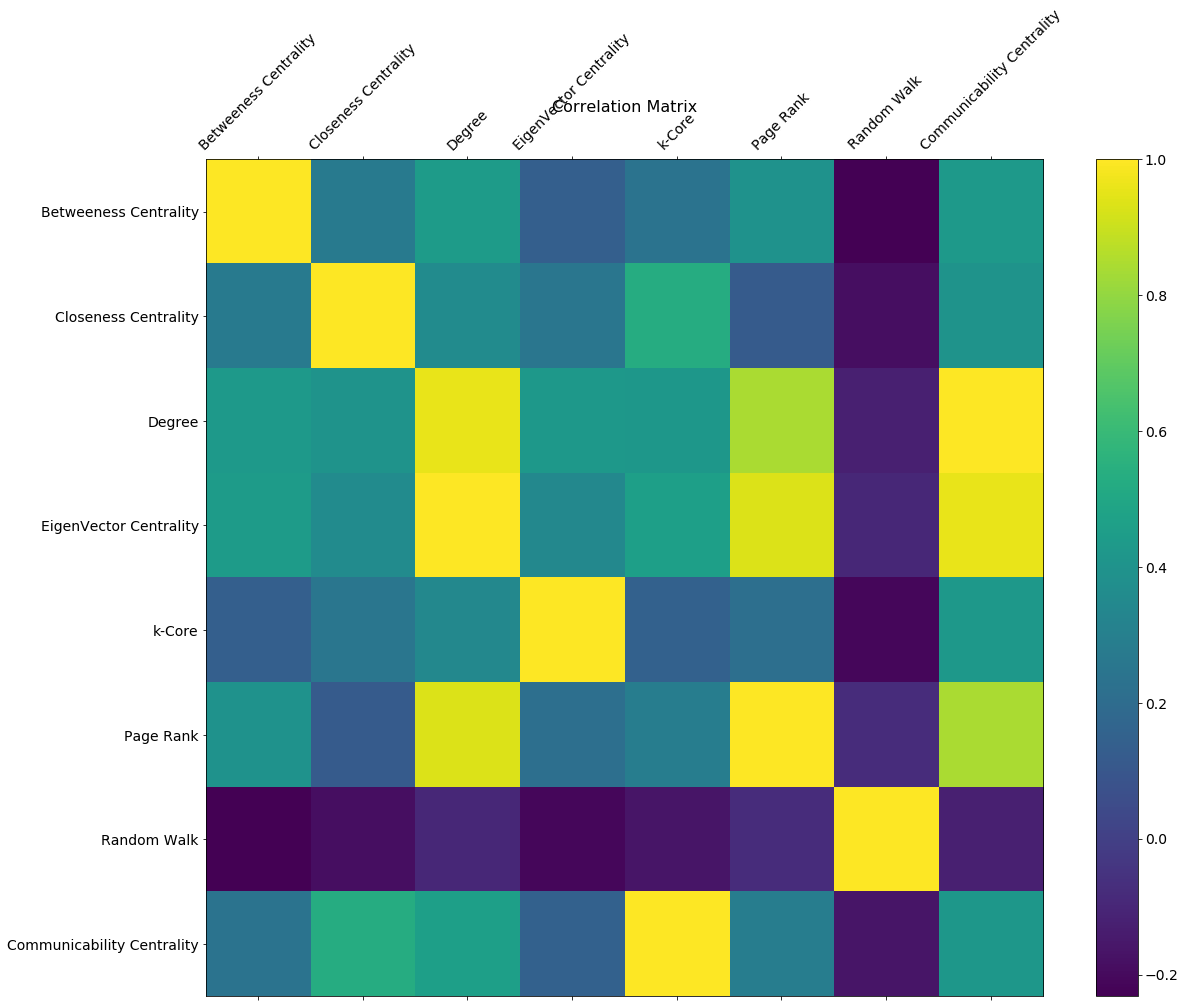

In [54]:
plotCorr(corr[e_road])
#plotCorr(corr[e_road][corr[e_road]<0.0])
#plotCorr(corr[e_road][corr[e_road]>6.0])
#plotCorr(corr[e_road][corr[e_road]>8.0])

## Questão 2

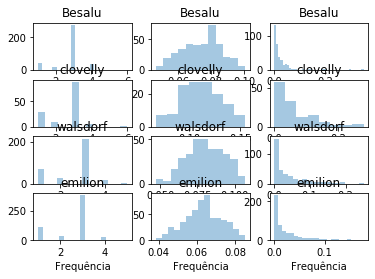

In [6]:
#Ajustar, pois as imagens estão pequenas.
plt.figure(figsize=(25,25));
fig, axis = plt.subplots(4,3)
ng = 0
metric= -1

for g, title in allCities:
    degree = degrees(g)
    closenessC = closenessCentrality(g)
    betweeness = betweenessCentrality(g)
    
    #Plotando
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Grau')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(degree, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Closeness Centrality')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(closenessC, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Betweeness Centrality')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(betweeness, hist=True, kde=False, ax=axis[ng,metric]);
    ng += 1


## Questão 3


<Figure size 7200x5760 with 0 Axes>

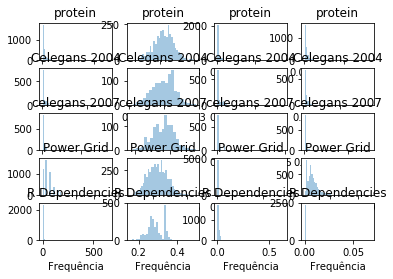

In [28]:
#Ajustar, pois as imagens estão pequenas.
fig, axis = plt.subplots(5,4)
ng = 0
metric= -1

for g, title in [(protein,'protein'), (celegans2004,'Celegans 2004'), (celegans2007,'celegans 2007'),\
                 (power_grid,'Power Grid'), (r_dependencies,'R Dependencies')]:
    
    degree = degrees(g)
    cc = closenessCentrality(g)
    ev = eigenVectorCentrality(g, max_iter = 10000) #1000 estava dando erro em um dos grafos.
    pr = pageRank(g)
    
    #Plotando
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Grau')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(degree, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Closeness Centrality')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(cc, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('EigenVector Centrality')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(ev, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Page Rank')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(pr, hist=True, kde=False, ax=axis[ng,metric]);
    ng += 1

## Questão 4

In [ ]:
graphData = []
graph_names = ['protein','Celegans 2004','celegans 2007','Power Grid','R Dependencies']

for g in [protein,celegans2004,celegans2007,power_grid,r_dependencies]:

    description = []
    d = degrees(g)
    cc = closenessCentrality(graph)
    kc= kCore(graph)
    bc = betweenessCentrality(graph)
    ec = eigenVectorCentrality(graph,1000)
    pr = pageRank(graph)
    rw = random_walk(graph,100)
    com = communicabilityCentrality(graph)

    for x in [d,kc,cc,bc,ec,pr,rw,com]:
        description.append(np.average(x))
        description.append(np.std(x))
        description.append(moment(x,2))
        description.append(shannonEntropy(x))

    graphData.append(description)



Text(0, 0.5, 'PC2')

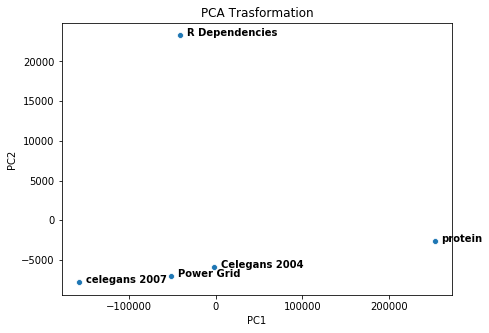

In [46]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(graphData)
transformed = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])

plt.figure(figsize=(7,5));
p1 = sns.scatterplot(x='PC 1',y='PC 2', data=transformed, legend=False);

for line in range(0,len(graphData)):
     p1.text(transformed['PC 1'][line]+8000, transformed['PC 2'][line]-100, graph_names[line],
     horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('PCA Trasformation')
plt.xlabel('PC1')
plt.ylabel('PC2')


Podemos ver que todas as redes possuem uma tendência entre os componentes 1 e 2, mas a rede R dependencies possui uma relação diferente.

### Questão 6

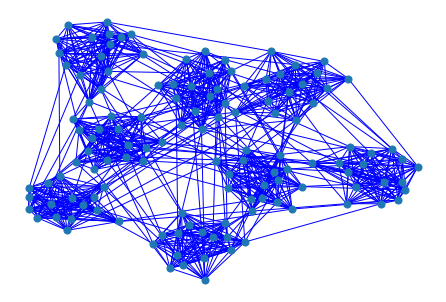

In [12]:
N = 128
tau1 = 3
tau2 = 1.5
mu = 0.04
k =16
minc = 16
maxc = 16
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 10)
pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, nodecolor='r', edge_color='b', 
        node_size=50, font_size=16,  width=1,pos = pos);
plt.show(True)

NameError: name 'community_louvain' is not defined

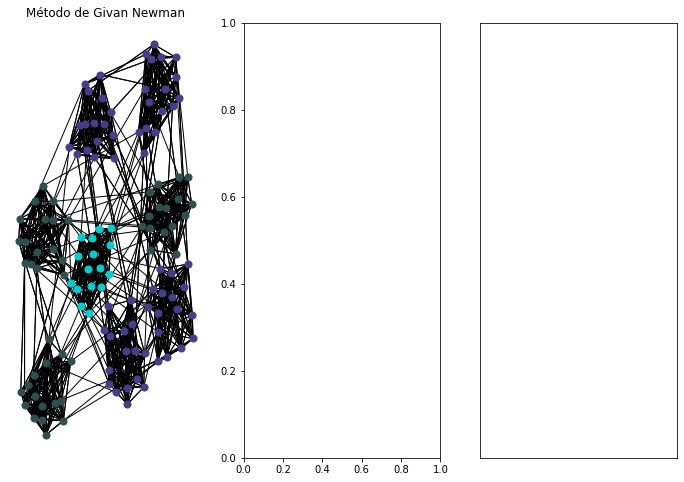

In [21]:
def select_givan_newman_comms(gn_comm, k=3):
    for i in range(k):
        comm = next(gn_comm)
    sorted_comms = sorted(map(sorted, comm))
    return sorted_comms
    
def plot_givan_newman(G, k=3, ax=-1):
    pos=nx.spring_layout(G)
    gn_comm = community.girvan_newman(G)
    
    sorted_comms = select_givan_newman_comms(gn_comm, k)
    
    colors = list(matplotlib.colors.cnames.values())
    aux = 35
    for comm in sorted_comms:
        nx.draw(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, 
                node_size=50, ax=ax)
        aux = aux + 1
    nx.draw_networkx_edges(G, pos, ax=ax)
    ax.set_title('Método de Givan Newman')

#Louvain
def plot_louvain(G, ax=-1):
    louvain_comm = community_louvain.best_partition(G)
    
    pos=nx.spring_layout(G)

    colors = list(matplotlib.colors.cnames.values())

    size = float(len(set(louvain_comm.values())))
    count = 0.
    for com in set(louvain_comm.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in louvain_comm.keys() if louvain_comm[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50, 
                               node_color = colors[int(count)], ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    ax.set_title('Método de Louvain')

def plot_label_prop(G, ax=-1):
    pos = nx.spring_layout(G)
    lp_comm = community.label_propagation_communities(G)

    colors = list(matplotlib.colors.cnames.values())
    aux = 35
    for comm in lp_comm:
        nx.draw(G.subgraph(comm), pos=pos, node_size = 50, node_color = colors[aux], ax=ax)
        aux = aux+1
        
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    ax.set_title('Método de label propagation')

fig, axis = plt.subplots(1,3, figsize=(12,8))

plot_givan_newman(G,k=3, ax=axis[0])
plot_louvain(G, ax=axis[1])
plot_label_prop(G, ax=axis[2])

### Questão 7

In [ ]:
fig, axis = plt.subplots(1,3, figsize=(8,8))
plt.subplots_adjust(right=1.4)
plot_givan_newman(karate, k=2, ax=axis[0])
plot_louvain(karate, axis[1])
plot_label_prop(karate, axis[2])